In [98]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [99]:
from google.colab import drive
drive.mount('/content/drive')
# !unzip '/content/drive/My Drive/Colab Notebooks/CS 412 - Machine Learning/Project/data.zip' -d '/content/drive/My Drive/Colab Notebooks/CS 412 - Machine Learning/Project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
scores_df = pd.read_csv('scores.csv')
print(scores_df.head())

   Unnamed: 0                                  code  grade
0           0  6a2003ad-a05a-41c9-9d48-e98491a90499   90.0
1           1  04f91058-d0f8-4324-83b2-19c671f433dc   97.0
2           2  81fdeb2a-e7e5-4a05-8058-d31ea579b0d9   94.0
3           3  6a903495-c5be-4263-b4dd-75e2bbc30434   97.0
4           4  6d5742c1-77c4-429c-8f6e-ef1262ca5557   93.0


In [101]:
data_path = "data/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:28<00:00,  4.41it/s]


In [102]:
# let's see one of the conversations
#code2convos: keeps all the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [103]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [104]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [105]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [106]:
##Reduce noises from texts###

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    return text

prompts = [preprocess_text(prompt) for prompt in prompts]
questions = [preprocess_text(question) for question in questions]

# print(prompts_cleaned)
# print(questions_cleaned)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [107]:
import gensim.downloader
from gensim.models import Word2Vec

sentences = [prompt.split() for prompt in prompts]

vector_size = 500
window = 5
min_count = 5

w2v_model = Word2Vec(
    sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4)

In [108]:
import gensim.downloader as api
import numpy as np

def document_vector(word2vec_model, doc):
    words = doc.split()
    word_vectors = []

    for word in words:
        if word in word2vec_model.wv:
            word_vectors.append(word2vec_model.wv[word])

    if not word_vectors:
        return np.zeros(word2vec_model.vector_size)

    document_vector = np.mean(word_vectors, axis=0)
    return document_vector

code2_word2vec_prompts = dict()

for code, user_prompts in code2prompts.items():
  if len(user_prompts) == 0:
      # some files have issues
      print(code+".html")
      continue

  word2_vec = pd.DataFrame([document_vector(w2v_model, doc) for doc in user_prompts],
                               columns={i: f"Q_{i}" for i in range(w2v_model.vector_size)})
  code2_word2vec_prompts[code] = word2_vec

question_word2vec = pd.DataFrame([document_vector(w2v_model, doc) for doc in questions], columns={i: f"Q_{i}" for i in range(w2v_model.vector_size)})

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [109]:
from sklearn.preprocessing import normalize
code2cosine = dict()
for code, user_prompts_word2vec in code2_word2vec_prompts.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(question_word2vec, user_prompts_word2vec))

code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()

question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.956003,0.860197,0.918025,0.891399,0.959316,0.882865,0.842396,0.848359,0.834536
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.934830,0.902552,0.965433,0.978993,0.934310,0.998846,0.988118,0.949657,0.976039
2,041f950b-c013-409a-a642-cffff60b9d4b,0.943798,0.888037,0.923433,0.804449,0.930145,0.866650,0.895797,0.925038,0.812732
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.921501,0.848850,0.851445,0.918374,0.932051,0.884884,0.889570,0.895911,0.975381
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.961097,0.916737,0.960444,0.918477,0.953698,0.979909,0.990485,0.993746,0.966788
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.953128,0.926478,0.901900,0.848231,0.895486,0.916243,0.998723,0.997564,0.987708
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.948534,0.920585,0.922374,0.971382,0.989850,0.986880,0.959403,0.995220,0.969427
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.972430,0.965359,0.987766,0.986073,0.991603,0.993088,0.985894,0.982788,0.972432
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.911021,0.976775,0.998416,0.968251,0.998597,0.992565,0.999603,0.999783,0.976612


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [110]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["great", "wrong", "problem", "error", "no", "thank", "next", "Entropy", "yes", "correct", "exactly", "certainly", "sure", "good", "well", "bad", "here", "how", ]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [111]:
# Threshold Feature

threshold_copy_paste = 0.8

for i in range(len(questions)):
    question_mapping_scores[f"copy_paste_indicator_Q{i}"] = (
        question_mapping_scores[f"Q_{i}"] > threshold_copy_paste
    ).astype(int)

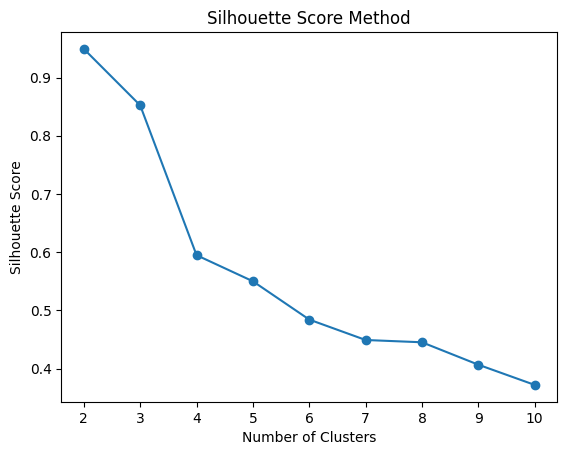

In [112]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

X = pd.DataFrame.from_dict(code2features, orient='index').fillna(0)

# Specify a range of cluster numbers to try
cluster_range = range(2, 11)

silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)  # Set n_init explicitly to 10 in order to suppress the warning
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

# Plot the Silhouette Score for different numbers of clusters
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


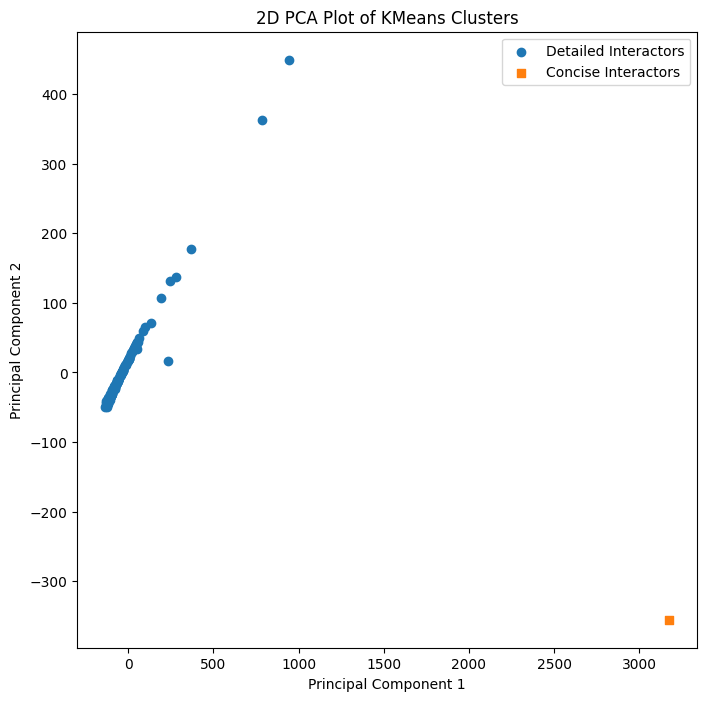

In [113]:
# k-means clustering and setting the number of cluster based on the highest silhouette score

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

X = pd.DataFrame.from_dict(code2features, orient='index').fillna(0)

# Number of clusters based on the silhouette score
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)

X['cluster_label'] = cluster_labels

#Cluster 0: Detailed Interactors (students who provide detailed prompts and responses)
#Cluster 1: Concise Interactors (students who use shorter prompts and responses)
cluster_label_mapping = {0: "Detailed Interactors", 1: "Concise Interactors"}
X['cluster_label'] = X['cluster_label'].map(cluster_label_mapping)
question_mapping_scores['is_detailed_instructor'] = np.where(X['cluster_label'] == 'Detailed Interactors', 1, 0)

# Plotting the clusters using PCA.

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.drop('cluster_label', axis=1))  # Ensure to drop non-numeric columns
X['pca_one'] = X_pca[:, 0]
X['pca_two'] = X_pca[:, 1]

plt.figure(figsize=(8, 8))
for cluster_label, marker in zip(cluster_label_mapping.values(), ['o', 's']):
    cluster_data = X[X['cluster_label'] == cluster_label]
    plt.scatter(cluster_data['pca_one'], cluster_data['pca_two'], label=cluster_label, marker=marker)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Plot of KMeans Clusters')
plt.legend()
plt.show()

In [114]:
from sklearn.preprocessing import normalize

df = pd.DataFrame(code2features).T

for column in df.columns:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)
df.head(5)

,#user_prompts,#great,#wrong,#problem,#error,#no,#thank,#next,#entropy,#yes,...,#exactly,#certainly,#sure,#good,#well,#bad,#here,#how,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.0,1.0,2.0,1.0,5.0,0.0,0.0,26.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,2.0,20.0,0.017986,18.850913


In [115]:
# reading the scores
scores = pd.read_csv("scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


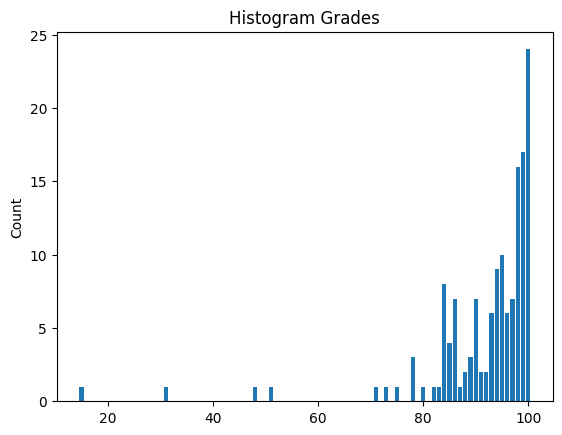

In [116]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [117]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#great,#wrong,#problem,#error,#no,#thank,#next,#entropy,...,#exactly,#certainly,#sure,#good,#well,#bad,#here,#how,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.0,1.0,2.0,1.0,5.0,0.0,0.0,26.0,...,1.0,0.0,1.0,0.0,0.0,1.0,2.0,20.0,0.017986,18.850913


In [118]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#great,#wrong,#problem,#error,#no,#thank,#next,#entropy,...,copy_paste_indicator_Q0,copy_paste_indicator_Q1,copy_paste_indicator_Q2,copy_paste_indicator_Q3,copy_paste_indicator_Q4,copy_paste_indicator_Q5,copy_paste_indicator_Q6,copy_paste_indicator_Q7,copy_paste_indicator_Q8,is_detailed_instructor
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,1,1,1,1,1,1,1,1,1,1
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,3.0,...,1,1,1,1,1,1,1,1,1,1
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,...,1,1,1,1,1,1,1,1,1,1
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.0,1.0,2.0,1.0,5.0,0.0,0.0,26.0,...,1,1,1,1,1,1,1,1,1,1


#### Merging scores with features

In [119]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#great,#wrong,#problem,#error,#no,#thank,#next,#entropy,...,copy_paste_indicator_Q1,copy_paste_indicator_Q2,copy_paste_indicator_Q3,copy_paste_indicator_Q4,copy_paste_indicator_Q5,copy_paste_indicator_Q6,copy_paste_indicator_Q7,copy_paste_indicator_Q8,is_detailed_instructor,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,1,1,1,1,1,1,1,1,1,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,3.0,...,1,1,1,1,1,1,1,1,1,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,...,1,1,1,1,1,1,1,1,1,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.0,1.0,2.0,1.0,5.0,0.0,0.0,26.0,...,1,1,1,1,1,1,1,1,1,100.0


In [120]:
from textblob import TextBlob

def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

for code, convos in code2convos.items():
    sentiments = [calculate_sentiment(convo["text"]) for convo in convos if convo["role"] == "user"]
    avg_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0
    code2features[code]["avg_sentiment"] = avg_sentiment

features_df = pd.DataFrame.from_dict(code2features, orient='index')
features_df.reset_index(inplace=True)
features_df.rename(columns={'index': 'code'}, inplace=True)

temp_df = pd.merge(temp_df, features_df[['code', 'avg_sentiment']], on='code', how='left')

In [121]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 41) (122,)


#### Train/Test split

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing

In [123]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# max_depth_arr = [i for i in range(1, max_depth + 1)]
# min_sample_splits = [i for i in range(2, 21)]

param_grid = {
    'max_depth': [5, 8, 12, 16],
    'min_samples_split': [2, 4, 10, 20]
}


regressor = RandomForestRegressor(n_estimators=200)
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

grid_search.fit(X_train, y_train)
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)
results.head(50)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
0,5,2,0.910401,0.140280
1,5,4,0.913035,0.146406
2,5,10,0.896061,0.160709
3,5,20,0.786911,0.236912
4,8,2,0.908576,0.150035
5,8,4,0.907596,0.142286
6,8,10,0.905980,0.150465
7,8,20,0.804485,0.251291
8,12,2,0.916641,0.137082
9,12,4,0.920476,0.132649


In [124]:
# OUR PRIMARY MODEL ISN'T THIS REGRESSOR. WE MERELY WANTED TO DEMONSTRATE THAT
# ADDING SENTIMENT ANALYSIS TO EACH  DOCUMENT IN THE FEATURE VECTOR RESULTS IN AN
# EXTREMELY HIGH R2 SCORE. THE MAIN MODEL THAT WE EMPLOY FOR PREDICTING GRADES IS SHOWN BELOW.

first_regressor = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth = results["param_max_depth"][0],
    min_samples_split = results["param_min_samples_split"][0]
)

first_regressor.fit(X_train, y_train)

# Predictionx
y_train_pred = first_regressor.predict(X_train)
y_test_pred = first_regressor.predict(X_test)

# Map predictions to the (0, 100) range
y_train_pred = np.clip(y_train_pred, 0, 100)
y_test_pred = np.clip(y_test_pred, 0, 100)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train, y_train_pred))
print("MSE TEST:", mean_squared_error(y_test, y_test_pred))

print("R2 Train:", r2_score(y_train, y_train_pred))
print("R2 TEST: ",r2_score(y_test, y_test_pred))

# Cross-validation
cv_scores = cross_val_score(first_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores
print("Cross-Validation Scores:", cv_scores)

MSE Train: 3.7391938472423636
MSE TEST: 0.86363425386616
R2 Train: 0.9771191652378131
R2 TEST:  0.9923072227479641
Cross-Validation Scores: [2.16589430e+01 4.09486588e-01 3.19673875e-01 2.08792908e+02
 9.10219798e-02]


In [125]:
temp_df = temp_df.drop("avg_sentiment", axis=1)
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 40) (122,)


In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


In [127]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# max_depth_arr = [i for i in range(1, max_depth + 1)]
# min_sample_splits = [i for i in range(2, 21)]

param_grid = {
    'max_depth': [5, 8, 12, 16],
    'min_samples_split': [2, 4, 10, 20]
}


regressor = RandomForestRegressor(n_estimators=200)
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

grid_search.fit(X_train, y_train)
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)
results.head(50)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
0,5,2,-0.764552,0.400177
1,5,4,-1.015240,0.753330
2,5,10,-0.917609,0.470100
3,5,20,-0.873879,0.430855
4,8,2,-0.851455,0.443753
5,8,4,-1.077287,0.594269
6,8,10,-0.998070,0.567589
7,8,20,-0.860540,0.415406
8,12,2,-0.841328,0.500777
9,12,4,-1.085261,0.648351


In [128]:
# THIS REGRESSOR IS OUR MAIN MODEL. WE ARE USING THIS MODEL TO PREDICT DATA.

main_regressor = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth = results["param_max_depth"][0],
    min_samples_split = results["param_min_samples_split"][0]
)

main_regressor.fit(X_train, y_train)

# Prediction
y_train_pred = main_regressor.predict(X_train)
y_test_pred = main_regressor.predict(X_test)

# Map predictions to the (0, 100) range
y_train_pred = np.clip(y_train_pred, 0, 100)
y_test_pred = np.clip(y_test_pred, 0, 100)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train, y_train_pred))
print("MSE TEST:", mean_squared_error(y_test, y_test_pred))

print("R2 Train:", r2_score(y_train, y_train_pred))
print("R2 TEST: ",r2_score(y_test, y_test_pred))

# Cross-validation
cv_scores = cross_val_score(main_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores
print("Cross-Validation Scores:", cv_scores)

MSE Train: 34.55089318554958
MSE TEST: 75.65092270327037
R2 Train: 0.788576546132381
R2 TEST:  0.32614333595268385
Cross-Validation Scores: [301.60246882  81.61635697  81.68690079 567.22264701  53.98111364]
